3. Apply mobilenet model combined with efficientnet, it will be a lightwt model.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate, Average
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, DepthwiseConv2D
from tensorflow.keras.layers import Concatenate, Input, Dropout, BatchNormalization


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, InceptionV3
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization, Concatenate, Multiply
)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# Define Squeeze-and-Excitation-like attention block
def channel_attention(input_tensor, ratio=8):
    channel = input_tensor.shape[-1]
    shared_dense_one = Dense(channel // ratio, activation='relu')
    shared_dense_two = Dense(channel, activation='sigmoid')

    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    scale = Multiply()([input_tensor, avg_pool])
    return scale

# Load base models (without top layers)
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
efficientnet = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
inception = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Fine-tune last 20 layers of each model
for model in [mobilenet, efficientnet, inception]:
    model.trainable = True
    for layer in model.layers[:-20]:
        layer.trainable = False

# Define input
input_layer = Input(shape=(224, 224, 3))

# MobileNetV2 branch
x1 = mobilenet(input_layer)
x1 = Conv2D(64, (1,1), activation="relu")(x1)
x1 = DepthwiseConv2D((3,3), activation="relu", padding='same')(x1)
x1 = channel_attention(x1)
x1 = GlobalAveragePooling2D()(x1)

# EfficientNetB0 branch
x2 = efficientnet(input_layer)
x2 = Conv2D(64, (1,1), activation="relu")(x2)
x2 = DepthwiseConv2D((3,3), activation="relu", padding='same')(x2)
x2 = channel_attention(x2)
x2 = GlobalAveragePooling2D()(x2)

# InceptionV3 branch
x3 = inception(input_layer)
x3 = Conv2D(64, (1,1), activation="relu")(x3)
x3 = DepthwiseConv2D((3,3), activation="relu", padding='same')(x3)
x3 = channel_attention(x3)
x3 = GlobalAveragePooling2D()(x3)

# Feature fusion
merged = Concatenate()([x1, x2, x3])
merged = BatchNormalization()(merged)

# Fully connected layers with increased Dropout
merged = Dropout(0.4)(merged)
merged = Dense(128, activation="relu")(merged)
merged = Dropout(0.4)(merged)

# Output layer (3 classes: Cotton, Polyester, Wool)
output = Dense(3, activation="softmax")(merged)

# Define model
model = Model(inputs=input_layer, outputs=output)

# Compile with label smoothing and a lower learning rate
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy() # Removing label_smoothing
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ input_layer_11[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ input_layer_11[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_v3 (Functional) │ (None, 5, 5, 2048)     │     21,802,784 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_288 (Conv2D)       │ (None, 7, 7, 64)       │         81,984 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_289 (Conv2D)       │ (None, 7, 7, 64)       │         81,984 │ efficientnetb0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_290 (Conv2D)       │ (None, 5, 5, 64)       │        131,136 │ inception_v3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_6        │ (None, 7, 7, 64)       │            640 │ conv2d_288[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_7        │ (None, 7, 7, 64)       │            640 │ conv2d_289[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_8        │ (None, 5, 5, 64)       │            640 │ conv2d_290[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ depthwise_conv2d_6[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ depthwise_conv2d_7[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ depthwise_conv2d_8[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 8)              │            520 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 8)              │            520 │ global_average_poolin… │
├──────────────────────

 Total params: 28,436,510 (108.48 MB)

 Trainable params: 4,818,187 (18.38 MB)

 Non-trainable params: 23,618,323 (90.10 MB)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Making Dataset

In [5]:
import os
import pandas as pd

In [8]:
# Define dataset directory
dataset_dir = "/content/drive/MyDrive/Projects/Fabric Project/Manvi/FabricOCTData_Augmented"

# Define classes and assign labels
class_labels = {"Cotton": 0, "Polyester": 1, "Wool": 2}

# Create a list to store image paths and labels
data = []

In [9]:
# Traverse the directory and collect image paths with labels
for fabric_type in os.listdir(dataset_dir):  # Cotton, Polyester, Wool
    fabric_path = os.path.join(dataset_dir, fabric_type)

    if os.path.isdir(fabric_path):  # Ensure it's a directory
        for subfolder in os.listdir(fabric_path):  # Cotton1, Cotton2, etc.
            subfolder_path = os.path.join(fabric_path, subfolder)

            if os.path.isdir(subfolder_path):  # Ensure it's a folder
                for image_name in os.listdir(subfolder_path):  # Image files
                    image_path = os.path.join(subfolder_path, image_name)

                    if image_name.endswith((".png", ".jpg", ".jpeg")):  # Ensure valid image
                        data.append([image_path, class_labels[fabric_type]])

In [10]:
# Convert to a Pandas DataFrame
df = pd.DataFrame(data, columns=["Image_Path", "Label"])

# Display dataset structure
print(df)

# Save as CSV for future use
df.to_csv("fabric_dataset.csv", index=False)


                                             Image_Path  Label
0     /content/drive/MyDrive/Projects/Fabric Project...      0
1     /content/drive/MyDrive/Projects/Fabric Project...      0
2     /content/drive/MyDrive/Projects/Fabric Project...      0
3     /content/drive/MyDrive/Projects/Fabric Project...      0
4     /content/drive/MyDrive/Projects/Fabric Project...      0
...                                                 ...    ...
1471  /content/drive/MyDrive/Projects/Fabric Project...      2
1472  /content/drive/MyDrive/Projects/Fabric Project...      2
1473  /content/drive/MyDrive/Projects/Fabric Project...      2
1474  /content/drive/MyDrive/Projects/Fabric Project...      2
1475  /content/drive/MyDrive/Projects/Fabric Project...      2

[1476 rows x 2 columns]


# Splitting

In [11]:
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("fabric_dataset.csv")  # The CSV we created earlier

# Split into train (70%), temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["Label"], random_state=42)

# Split temp into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["Label"], random_state=42)

# Display the split sizes
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")


Train: 1033, Validation: 221, Test: 222


# Loading and Preprocessing

In [12]:
import numpy as np

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = (224, 224)  # Resize all images to 224x224

def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)  # Load and resize image
    img = img_to_array(img) / 255.0  # Convert to array & normalize
    return img

# Convert file paths into NumPy arrays for TensorFlow
train_images = np.array([load_and_preprocess_image(img) for img in train_df["Image_Path"]])
val_images = np.array([load_and_preprocess_image(img) for img in val_df["Image_Path"]])
test_images = np.array([load_and_preprocess_image(img) for img in test_df["Image_Path"]])

# Convert labels to NumPy arrays
train_labels = np.array(train_df["Label"])
val_labels = np.array(val_df["Label"])
test_labels = np.array(test_df["Label"])


# Training

In [16]:

# Train
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=16)


Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 78s 722ms/step - accuracy: 0.9021 - loss: 0.4273 - val_accuracy: 0.8688 - val_loss: 0.7603
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9261 - loss: 0.3617 - val_accuracy: 0.8824 - val_loss: 0.6362
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.9068 - loss: 0.3739 - val_accuracy: 0.8869 - val_loss: 0.5169
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9393 - loss: 0.2954 - val_accuracy: 0.9050 - val_loss: 0.4172
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9380 - loss: 0.2942 - val_accuracy: 0.9050 - val_loss: 0.3418
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.9636 - loss: 0.2365 - val_accuracy: 0.9140 - val_loss: 0.2976
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9710 - loss: 0.2202 - val_accuracy: 0.9231 - val_loss: 0.2550
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9701 - loss: 0.2084 - val_accuracy: 0.9

# Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
              precision    recall  f1-score   support

      Cotton       0.99      0.99      0.99        75
   Polyester       0.96      0.97      0.96        67
        Wool       0.97      0.96      0.97        80

    accuracy                           0.97       222
   macro avg       0.97      0.97      0.97       222
weighted avg       0.97      0.97      0.97       222



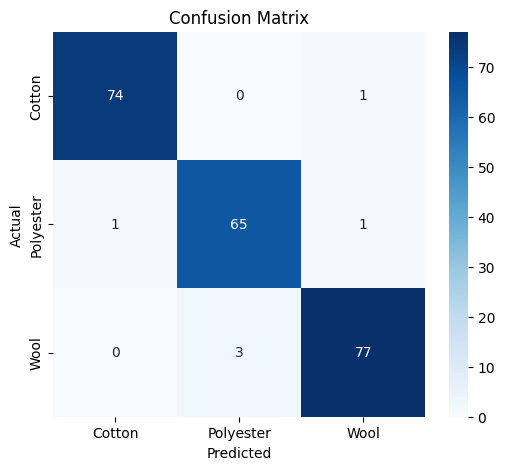

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = np.argmax(model.predict(test_images), axis=1)

# Print classification report
print(classification_report(test_labels, y_pred, target_names=["Cotton", "Polyester", "Wool"]))

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cotton", "Polyester", "Wool"], yticklabels=["Cotton", "Polyester", "Wool"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
def get_flops(model):
    """Calculates the number of FLOPs for a given model.

    Args:
        model: The Keras model.

    Returns:
        The total number of FLOPs.
    """
    from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

    # Convert Keras model to ConcreteFunction
    concrete_func = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete_func.get_concrete_function(
        [tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)]
    )

    # Get frozen ConcreteFunction
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

    # Calculate FLOPs using the frozen graph
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

# Calculate FLOPs for your model
flops = get_flops(model)
print(f"Total FLOPs: {flops}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_2159
Received: inputs=['Tensor(shape=(None, 224, 224, 3))']
  warnings.warn(msg)
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Total FLOPs: 315619
